In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import pandas as pd
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
import time


In [ ]:
# Loading AFLW2000 Data
## not to run
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

# draw axis

In [3]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# draw landmarks

In [4]:
def show_image_with_landmarks(image_path, pitch=None, yaw=None, roll=None):
    # Load face mesh model
    faceModule = mp.solutions.face_mesh

    # Load image
    image = cv2.imread(image_path)

    # Extract labels for pitch, yaw, and roll
    if pitch is None or yaw is None or roll is None:
        try:
            # Try to load mat file
            mat_file = sio.loadmat(image_path.replace('.jpg', '.mat'))
            pose_para = mat_file["Pose_Para"][0][:3]
            pitch = pose_para[0]
            yaw = pose_para[1]
            roll = pose_para[2]
        except FileNotFoundError:
            # If mat file not found, set pitch, yaw, roll to None
            pitch = yaw = roll = None

    # Create a copy of the original image
    image_with_landmarks = image.copy()

    # Use mediapipe to extract facial landmarks, including the nose
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Extract nose coordinates
        if results.multi_face_landmarks and len(results.multi_face_landmarks) > 0:
            nose_landmark = results.multi_face_landmarks[0].landmark[4]  # Assuming 4 is the landmark index for the nose
            nose_x = nose_landmark.x * image.shape[1]
            nose_y = nose_landmark.y * image.shape[0]
            landmarks_data = []
            # Draw landmarks on the image copy
            for face_landmarks in results.multi_face_landmarks:
                for landmark in face_landmarks.landmark:
                    x = landmark.x * image.shape[1]  # multiply x with width (index 1 of . shape) of the image to bring coordinates
                    y = landmark.y * image.shape[0]
                    landmarks_data.extend([x,y])
                    cv2.circle(image_with_landmarks, (int(x), int(y)), radius=1, color=(0, 255, 0), thickness=2)

            # Display the image with facial landmarks, nose coordinates, and axes
            cv2_imshow(image_with_landmarks)

            # Return nose coordinates, pitch, yaw, and roll
            return image, pitch, yaw, roll, nose_x, nose_y,landmarks_data
        else:
            print("No face or landmarks detected.")
            return None


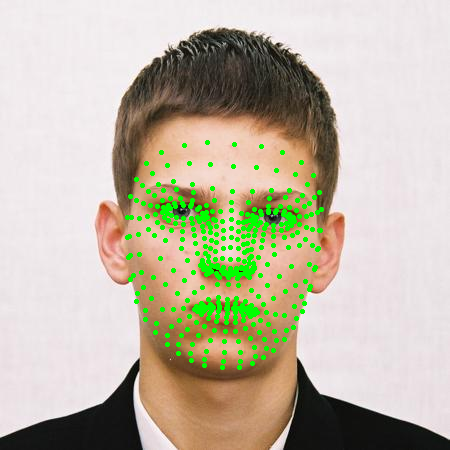

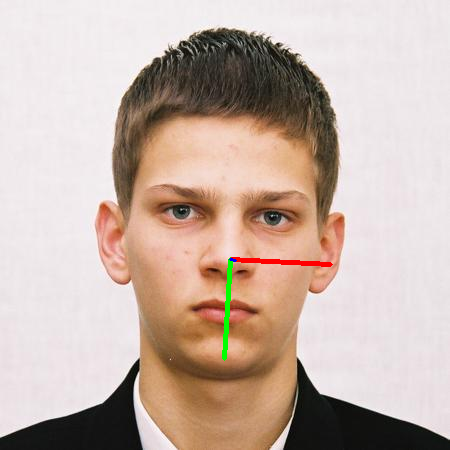

In [ ]:
image_path = '/content/AFLW2000/image00039.jpg'

image,pitch,yaw,roll,nose_x,nose_y,landmarks = show_image_with_landmarks(image_path)
axis_image=draw_axis(image.copy(),pitch,yaw,roll,nose_x,nose_y)
cv2_imshow(axis_image)

# extract dataframe

In [ ]:

faceModule = mp.solutions.face_mesh
directory_path = '/content/AFLW2000/'
# List to store data
data_list = []

for filename in os.listdir(directory_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(directory_path, filename)
        image = cv2.imread(image_path)
        mat_file = sio.loadmat(image_path[:-4] + '.mat')

        pose_para = mat_file["Pose_Para"][0][:3]
        pitch = pose_para[0]
        yaw = pose_para[1]
        roll = pose_para[2]

        landmarks_data = []
        nose_coordinates = None  # Variable to store nose coordinates
        with faceModule.FaceMesh(static_image_mode=True, max_num_faces=1) as faces:
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            if results.multi_face_landmarks and len(results.multi_face_landmarks) > 0:
                nose_landmark = results.multi_face_landmarks[0].landmark[2]
                nose_x = (nose_landmark.x * image.shape[1])
                nose_y = (nose_landmark.y * image.shape[0])
                nose_coordinates = (nose_x, nose_y)

                for i, face_landmarks in enumerate(results.multi_face_landmarks, start=1):
                    for j, landmark in enumerate(face_landmarks.landmark, start=1):
                        x = (landmark.x * image.shape[1])
                        y = (landmark.y * image.shape[0])
                        landmarks_data.extend([x, y])

                # Add the data to the list
                data_list.append([filename, pitch, yaw, roll] + landmarks_data)


In [ ]:
len(data_list[0])

940

In [ ]:
# Create DataFrame from the list with correct columns for X and Y coordinates
columns = ['Image', 'Pitch', 'Yaw', 'Roll']
for i in range(1, 469):
    columns.extend([f'Landmark_{i}_X', f'Landmark_{i}_Y'])

df = pd.DataFrame(data_list, columns=columns)

In [ ]:
df.head()

,Image,Pitch,Yaw,Roll,Landmark_1_X,Landmark_1_Y,Landmark_2_X,Landmark_2_Y,Landmark_3_X,Landmark_3_Y,...,Landmark_464_X,Landmark_464_Y,Landmark_465_X,Landmark_465_Y,Landmark_466_X,Landmark_466_Y,Landmark_467_X,Landmark_467_Y,Landmark_468_X,Landmark_468_Y
0,image02769.jpg,-0.620480,0.802981,-0.492186,208.962321,347.734746,175.752845,311.011416,202.182099,315.277094,...,227.609709,208.523431,220.591803,215.478614,213.926286,221.784192,285.947862,191.284364,292.473891,181.065202
1,image00967.jpg,-0.140357,0.416353,-0.154847,219.363365,291.751707,206.767899,275.418985,215.513603,280.226737,...,235.252476,227.159983,230.921835,229.595241,227.355194,231.663895,269.736135,218.648127,274.079275,215.031999
2,image00350.jpg,-0.359845,-0.079327,0.073113,227.058327,308.708096,232.293195,289.573324,229.301003,292.718804,...,253.025597,222.052427,248.518708,225.344235,246.396732,228.598425,294.630522,216.950409,298.137885,214.458972
3,image01950.jpg,-1.226964,-1.390229,1.069831,263.352478,293.097290,279.040235,271.215212,261.038643,279.499215,...,250.542542,225.904012,250.938141,228.746429,253.586555,230.859017,256.789273,221.733324,256.770578,217.782658
4,image01168.jpg,0.019266,0.192534,-0.032207,217.300048,305.133328,214.445280,272.751662,217.491210,282.655585,...,243.539053,219.798593,238.233000,222.184552,234.824020,223.695306,282.968330,213.359696,287.504241,210.284436


In [ ]:
df.shape

(1853, 940)

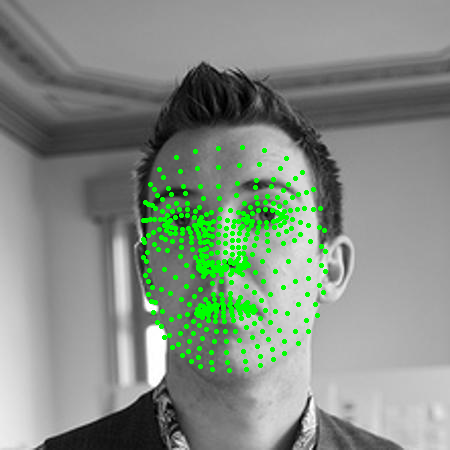

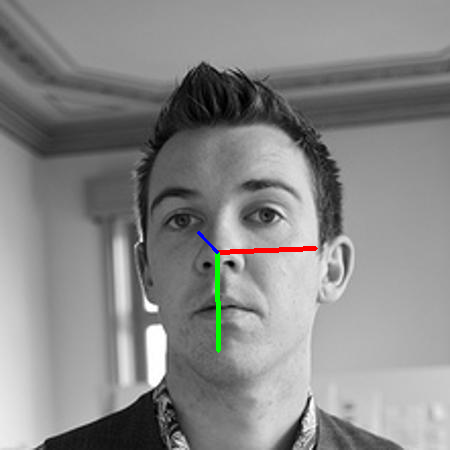

In [ ]:
image_path = "/content/AFLW2000/"+df.loc[10,"Image"]
image,pitch,yaw,roll,nose_x,nose_y,landmarks_data= show_image_with_landmarks(image_path,df.loc[10,"Pitch"],df.loc[10,"Yaw"],df.loc[10,"Roll"])
axis_image=draw_axis(image.copy(),pitch,yaw,roll,nose_x,nose_y)
cv2_imshow(axis_image)

# normalize dataframe

In [5]:
def normalize_landmarks(df, nose_index, chain_index):
    # Extract nose and chain landmark coordinates
    nose_landmark_x = df[f'Landmark_{nose_index}_X']
    nose_landmark_y = df[f'Landmark_{nose_index}_Y']


    # Subtract nose landmark coordinates from all other landmarks
    for i in range(1, 469):
        df[f'Landmark_{i}_X'] = df[f'Landmark_{i}_X'] - nose_landmark_x
        df[f'Landmark_{i}_Y'] = df[f'Landmark_{i}_Y'] - nose_landmark_y

    # Calculate the distance between nose and chain landmarks
    chain_landmark_x = df[f'Landmark_{chain_index}_X']
    chain_landmark_y = df[f'Landmark_{chain_index}_Y']
    distance = np.sqrt(chain_landmark_x**2 + chain_landmark_y**2)

    # Normalize all landmark coordinates by dividing by the distance
    for i in range(1, 469):
        df[f'Landmark_{i}_X'] = df[f'Landmark_{i}_X'] / distance
        df[f'Landmark_{i}_Y'] = df[f'Landmark_{i}_Y'] / distance

    return df

In [ ]:
df_normalized = normalize_landmarks(df, nose_index=4, chain_index=153)

In [ ]:
df_normalized.to_csv("normalized_data.csv")

# train different models

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [7]:
df=pd.read_csv("/content/normalized_data.csv")


In [8]:
df.head(2)

,Unnamed: 0,Image,Pitch,Yaw,Roll,Landmark_1_X,Landmark_1_Y,Landmark_2_X,Landmark_2_Y,Landmark_3_X,...,Landmark_464_X,Landmark_464_Y,Landmark_465_X,Landmark_465_Y,Landmark_466_X,Landmark_466_Y,Landmark_467_X,Landmark_467_Y,Landmark_468_X,Landmark_468_Y
0,0,image02769.jpg,-0.620480,0.802981,-0.492186,0.215298,0.464000,0.023633,0.252055,0.176167,...,0.322920,-0.339443,0.282416,-0.299302,0.243947,-0.262910,0.659612,-0.438936,0.697276,-0.497915
1,1,image00967.jpg,-0.140357,0.416353,-0.154847,0.145680,0.385206,0.024715,0.228350,0.108707,...,0.298275,-0.235120,0.256685,-0.211732,0.222431,-0.191865,0.629450,-0.316866,0.671160,-0.351595


In [9]:
df.drop(columns="Unnamed: 0",inplace=True)

In [10]:
df.head(2)

,Image,Pitch,Yaw,Roll,Landmark_1_X,Landmark_1_Y,Landmark_2_X,Landmark_2_Y,Landmark_3_X,Landmark_3_Y,...,Landmark_464_X,Landmark_464_Y,Landmark_465_X,Landmark_465_Y,Landmark_466_X,Landmark_466_Y,Landmark_467_X,Landmark_467_Y,Landmark_468_X,Landmark_468_Y
0,image02769.jpg,-0.620480,0.802981,-0.492186,0.215298,0.464000,0.023633,0.252055,0.176167,0.276674,...,0.322920,-0.339443,0.282416,-0.299302,0.243947,-0.262910,0.659612,-0.438936,0.697276,-0.497915
1,image00967.jpg,-0.140357,0.416353,-0.154847,0.145680,0.385206,0.024715,0.228350,0.108707,0.274523,...,0.298275,-0.235120,0.256685,-0.211732,0.222431,-0.191865,0.629450,-0.316866,0.671160,-0.351595


# RandomForest

In [11]:
# Extract features (landmark coordinates) and targets (yaw, pitch, roll)
features = df.iloc[:,4:]  # Exclude 'Image' and pose columns
targets = df[['Pitch', 'Yaw', 'Roll']]

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.2, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=100)

In [12]:
# Train a regression model (Random Forest Regressor in this example)
model1 = RandomForestRegressor(n_estimators=100, random_state=42)
model1.fit(X_train, y_train['Yaw'])

model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(X_train, y_train['Pitch'])

model3 = RandomForestRegressor(n_estimators=100, random_state=42)
model3.fit(X_train, y_train['Roll'])

RandomForestRegressor(random_state=42)

In [13]:
# Make predictions on the validation set
yaw_predictions = model1.predict(X_val)
pitch_predictions = model2.predict(X_val)
roll_predictions = model3.predict(X_val)

mse1 = mean_squared_error(y_val['Yaw'], yaw_predictions)
mse2 = mean_squared_error(y_val['Pitch'], pitch_predictions)
mse3 = mean_squared_error(y_val['Roll'], roll_predictions)

print(f'mean square error: {mse1,mse2, mse3}')

mean square error: (0.01401441442993214, 0.03485472858605784, 0.03054607416114809)


In [16]:
test_yaw = model1.predict(X_test)
test_pitch = model2.predict(X_test)
test_roll = model3.predict(X_test)

mse1 = mean_squared_error(y_test['Yaw'], test_yaw)
mse2 = mean_squared_error(y_test['Pitch'], test_pitch)
mse3 = mean_squared_error(y_test['Roll'], test_roll)

print(f'mean square error: {mse1,mse2, mse3}')


r_test1 = model1.score(X_test, y_test['Yaw'])
r_test2 = model2.score(X_test, y_test['Pitch'])
r_test3 = model3.score(X_test, y_test['Roll'])
print(f'score: {r_test1,r_test2,r_test3}')

mean square error: (0.039836805759932176, 0.0828430703607309, 0.0692813252738338)
score: (0.8771512884339412, 0.4025081111504003, 0.6018176302309857)


In [17]:
from joblib import dump
dump(model1, 'model1_RF.joblib')
dump(model2, 'model2_RF.joblib')
dump(model3, 'model3_RF.joblib')


['model3_RF.joblib']

# GradientBoostingRegressor

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting Regressors
model1 = GradientBoostingRegressor()
model1.fit(X_train, y_train['Yaw'])

model2 = GradientBoostingRegressor()
model2.fit(X_train, y_train['Pitch'])

model3 = GradientBoostingRegressor()
model3.fit(X_train, y_train['Roll'])

GradientBoostingRegressor()

In [19]:
y_pred1 = model1.predict(X_val)
y_pred2 = model2.predict(X_val)
y_pred3 = model3.predict(X_val)

mse1 = mean_squared_error(y_val['Yaw'], y_pred1)
mse2 = mean_squared_error(y_val['Pitch'], y_pred2)
mse3 = mean_squared_error(y_val['Roll'], y_pred3)

print(f'Validation MSE Scores: {mse1, mse2, mse3}')

Validation MSE Scores: (0.0152545638282683, 0.03773538068251953, 0.03149151706510319)


In [20]:
# Evaluate R2 Score on Validation Set
r1 = model1.score(X_val, y_val['Yaw'])
r2 = model2.score(X_val, y_val['Pitch'])
r3 = model3.score(X_val, y_val['Roll'])
print(f'Validation R2 Score: {r1, r2, r3}')

Validation R2 Score: (0.9526466791304579, 0.5748883209245295, 0.7183375387832144)


In [23]:
r_test1 = model1.score(X_test, y_test['Yaw'])
r_test2 = model2.score(X_test, y_test['Pitch'])
r_test3 = model3.score(X_test, y_test['Roll'])
print(f'Test R2 Score: {r_test1, r_test2, r_test3}')

Test R2 Score: (0.8647545958217037, -0.3549449187510756, 0.6038805421296404)


In [24]:
from joblib import dump
dump(model1, 'model1_GB.joblib')
dump(model2, 'model2_GB.joblib')
dump(model3, 'model3_GB.joblib')


['model3_GB.joblib']

# SVR

In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define parameter grid for grid search
param_grid = {
    'C': np.power(10,np.arange(0,3,1,dtype=float)),
    'epsilon': np.arange(0,0.1,0.02)
}

# Create SVR instances
model1_svr = SVR()
model2_svr = SVR()
model3_svr = SVR()

# Perform grid search for each model
grid_search1 = GridSearchCV(model1_svr, param_grid, cv=5)
grid_search2 = GridSearchCV(model2_svr, param_grid, cv=5)
grid_search3 = GridSearchCV(model3_svr, param_grid, cv=5)

# Fit the models with the best hyperparameters
grid_search1.fit(X_train, y_train['Yaw'])
grid_search2.fit(X_train, y_train['Pitch'])
grid_search3.fit(X_train, y_train['Roll'])

# Get the best hyperparameters
best_params1 = grid_search1.best_params_
best_params2 = grid_search2.best_params_
best_params3 = grid_search3.best_params_

print(f'Best Hyperparameters Yaw: {best_params1}')
print(f'Best Hyperparameters Pitch: {best_params2}')
print(f'Best Hyperparameters Roll: {best_params3}')



Best Hyperparameters Yaw: {'C': 100.0, 'epsilon': 0.06}
Best Hyperparameters Pitch: {'C': 1.0, 'epsilon': 0.0}
Best Hyperparameters Roll: {'C': 1.0, 'epsilon': 0.02}


In [26]:
from sklearn.svm import SVR

# Train Support Vector Regressors
model1 = SVR(C=100,epsilon=0.06)
model1.fit(X_train, y_train['Yaw'])

model2 = SVR(C=1.0,epsilon=0.0)
model2.fit(X_train, y_train['Pitch'])

model3 = SVR(C=1,epsilon=0.02)
model3.fit(X_train, y_train['Roll'])

SVR(C=1, epsilon=0.02)

In [27]:
# Evaluate R2 Score on Test Set
y_pred1 = model1.predict(X_val)
y_pred2 = model2.predict(X_val)
y_pred3 = model3.predict(X_val)

mse1 = mean_squared_error(y_val['Yaw'], y_pred1)
mse2 = mean_squared_error(y_val['Pitch'], y_pred2)
mse3 = mean_squared_error(y_val['Roll'], y_pred3)
print(f'Validation MSE Scores: {mse1, mse2, mse3}')


r1 = model1.score(X_val,y_val['Yaw'])
r2 = model2.score(X_val,y_val['Pitch'])
r3 = model3.score(X_val,y_val['Roll'])
print(f'Validation R2 Score: {r1, r2, r3}')

Validation MSE Scores: (0.012496866800677913, 0.03367388718297771, 0.029875147847699197)
Validation R2 Score: (0.9612071410144273, 0.6206434793439106, 0.7327944647886484)


In [28]:
# Evaluate R2 Score on Test Set
r_test1 = model1.score(X_test,y_test['Yaw'])
r_test2 = model2.score(X_test,y_test['Pitch'])
r_test3 = model3.score(X_test,y_test['Roll'])

print(f'Test R2 Score: {r_test1, r_test2, r_test3}')

Test R2 Score: (0.8855448783383889, 0.45002480836578884, 0.6076237021254433)


In [29]:
from joblib import dump
dump(model1, 'model1_SVR.joblib')
dump(model2, 'model2_SVR.joblib')
dump(model3, 'model3_SVR.joblib')


['model3_SVR.joblib']

# test model

In [ ]:
from joblib import load
model1 = load('/content/model1_RF.joblib')
model2 = load('/content/model2_RF.joblib')
model3 = load('/content/model3_RF.joblib')

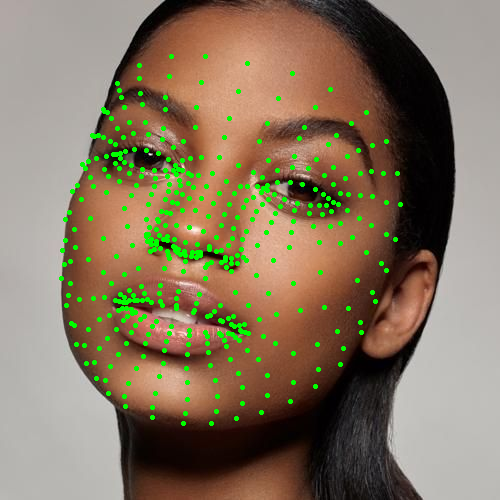

Predicted Yaw: [0.13456987]
Predicted Pitch: [0.22970556]
Predicted Roll: [0.27745247]


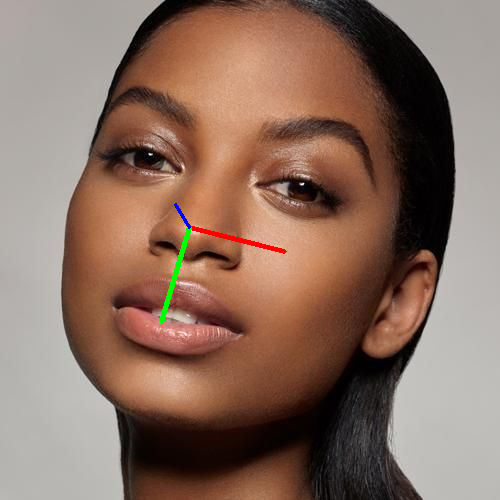

In [ ]:
# Load the new image
new_image_path = "/content/2.jpg"
new_image, pitch, yaw, roll, nose_x, nose_y,landmarks_data = show_image_with_landmarks(new_image_path,None,None,None)

landmarks_data = np.array(landmarks_data)
landmarks_data = landmarks_data.reshape(1,936)
# Prepare the feature vector
columns=[]
for i in range(1, 469):
    columns.extend([f'Landmark_{i}_X', f'Landmark_{i}_Y'])

df = pd.DataFrame(landmarks_data, columns=columns)
df_normalized = normalize_landmarks(df, nose_index=4, chain_index=153)

# Use the trained model to predict yaw, pitch, and roll
yaw_value = model1.predict(df_normalized)
Pitch_value = model2.predict(df_normalized)
roll_value = model3.predict(df_normalized)

# Print or use the predicted values as needed
print("Predicted Yaw:", yaw_value)
print("Predicted Pitch:", Pitch_value)
print("Predicted Roll:", roll_value)

# Draw the axes on the image using the predicted values
image_with_axes = draw_axis(new_image.copy(),Pitch_value,yaw_value,roll_value, nose_x, nose_y)
cv2_imshow(image_with_axes)

# video

In [ ]:
# Load the video
video_path = "/content/The way they matched each other's energy😂😂#friendstvshow #friends #comedy #fyp.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize the MediaPipe Face Mesh model
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, min_detection_confidence=0.5)

# Initialize an empty list to store the landmarks
landmarks = []

# Define the output video path
output_path = "/content/output.mp4"

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with the Face Mesh model
    results = face_mesh.process(frame_rgb)

    # Extract the landmarks
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks_data = []
            for landmark in face_landmarks.landmark:
                landmarks_data.extend([landmark.x, landmark.y])

            landmarks_data = np.array(landmarks_data)
            landmarks_data = landmarks_data.reshape(1,936)
            # Prepare the feature vector
            columns=[]
            for i in range(1, 469):
                columns.extend([f'Landmark_{i}_X', f'Landmark_{i}_Y'])

            df = pd.DataFrame(landmarks_data, columns=columns)
            nose_x = float(df["Landmark_5_X"])
            nose_y = float(df["Landmark_5_Y"])
            df_normalized = normalize_landmarks(df.copy(), nose_index=4, chain_index=153)

            # Use the trained model to predict yaw, pitch, and roll
            yaw_value = model1.predict(df_normalized)
            Pitch_value = model2.predict(df_normalized)
            roll_value = model3.predict(df_normalized)
            # Draw the axis on the frame
            frame = draw_axis(frame, Pitch_value, yaw_value, roll_value, nose_x * frame.shape[1], nose_y * frame.shape[0])

    # Write the frame with the drawn head pose to the output video
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()

print("Output video saved at:", output_path)


Output video saved at: /content/output.mp4
